In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

import matplotlib

from pareto_functions import *
from utils import box_plot, filter_df, vectorizers_order2, line_plot, heatmap_plot, corr_plot
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
#matplotlib.rcParams['text.usetex'] = True

import plotly.express as px
import plotly.io as pio

input_dir_sa = '../logs/schema_agnostic/core/'
input_dir_bl = '../logs/baseline/'
case_order = [f'D{i}' for i in range(1, 11)]
case_order2 = [f'DSM{i}' for i in range(1, 6)]

case_map = {'rest1_rest2': 'D1', 'abt_buy': 'D2', 'amazon_gp': 'D3',
            'dblp_acm': 'D4', 'imdb_tvdb': 'D5', 'tmdb_tvdb': 'D6', 'imdb_tmdb': 'D7',
            'walmart_amazon': 'D8', 'dblp_scholar': 'D9', 'imdb_dbpedia': 'D10' }

sizes = {'D1': 339*2256, 'D2': 1076*1076, 'D3': 1354*3039, 'D4': 2616*2294, 'D5': 5118*6056,
         'D6': 5118*7810, 'D7': 6056*7810, 'D8': 2554*22074, 'D9': 2516*61353, 'D10': 27615*23182}

categories = {'AT':'BERT', 'BT':'BERT', 'DT':'BERT', 'RA':'BERT', 'XT':'BERT', 
              'S5':'SBERT', 'SA':'SBERT', 'SM':'SBERT', 'ST':'SBERT',
              'FT':'Static', 'GE':'Static', 'WC':'Static', }

f_sch = ('Columns', 'ne', 2)
f_agn = ('Columns', 'eq', 2)
f_q2i = ('Direction', 'eq', 'q2i')
f_i2q = ('Direction', 'eq', 'i2q')
f_exa = ('Exact', 'eq', 'exact')
f_app = ('Exact', 'eq', 'approx')
f_k = ('k', 'eq', 10)

# Real Data

## Vectorization

In [2]:
with open(input_dir_sa + 'vectorization_real.txt') as f:
    lines = []
    for line in f.readlines():
        line = json.loads(line)
        
        lines.append((line['dir'], line['vectorizer'], line['init_time'], line['time'], line['file'],
                      line['column']['name'], line['memory']['process']['rss'],
                      line['memory']['total']['used']))
    
vec_df = pd.DataFrame(lines, columns=['Case', 'Vectorizer', 'Init Time', 'Total Time', 'File',
                                        'Column', 'Memory Process', 'Memory Total'])

vec_df['Case'] = vec_df['Case'].apply(lambda x: x.split('(')[0])
vec_df['Vectorizer'] = vec_df['Vectorizer'].apply(lambda x: x[0]+x[-1]).str.upper()

# Load Data

## Blocking

In [3]:
block_df = pd.read_csv(input_dir_sa + 'blocking_euclidean_real.csv')

block_df['Vectorizer'] = block_df['Vectorizer'].apply(lambda x: x[0]+x[-1]).str.upper()
block_df['F1'] = block_df.apply(lambda x: 2*x['Recall']*x['Precision'] / (x['Recall']+x['Precision']) if x['Recall']+x['Precision'] > 0 else 0, axis=1)
print(block_df.shape)

tuples = [('D1', 0), ('D2', 0), ('D3', 0), ('D4', 0), ('D5', 1), ('D6', 0), ('D7', 0), ('D8', 0), ('D9', 0), ('D10', 0), 
          ('D1', 2), ('D2', 2), ('D3', 2), ('D4', 2), ('D5', 2), ('D6', 2), ('D7', 2), ('D8', 2), ('D9', 2), ('D10', 2)]

block_df = block_df.loc[block_df.apply(lambda x: (x['Case'], x['Columns']) in tuples, axis=1)]
print(block_df.shape)
block_df = filter_df(block_df, [f_i2q, f_exa])
print(block_df.shape)
block_df

(360, 11)
(360, 11)
(360, 11)


,Unnamed: 0,Case,Columns,Vectorizer,k,Direction,Exact,Recall,Precision,Time,F1
0,2,D1,2,WC,1,i2q,exact,0.674157,0.026596,0.024570,0.051173
1,1,D1,2,WC,5,i2q,exact,0.775281,0.006117,0.100599,0.012138
2,2,D1,2,WC,10,i2q,exact,0.831461,0.003280,0.196642,0.006535
3,3,D1,2,FT,1,i2q,exact,0.932584,0.036791,0.027583,0.070789
4,4,D1,2,FT,5,i2q,exact,0.955056,0.007535,0.117201,0.014953
...,...,...,...,...,...,...,...,...,...,...,...
355,355,D10,2,SA,5,i2q,exact,0.342081,0.067475,1.157883,0.112716
356,356,D10,2,SA,10,i2q,exact,0.379740,0.037451,2.033820,0.068179
357,357,D10,2,SM,1,i2q,exact,0.297774,0.293676,0.401174,0.295711
358,358,D10,2,SM,5,i2q,exact,0.404146,0.079717,1.069517,0.133167


In [4]:
import json
import math
import statistics
import pandas as pd

base_stats = []
with open(input_dir_bl + 'TokenJoin.txt') as f:
    for line in f:
        j = json.loads(line)
        j['vec'] = 'TokenJoin'
        base_stats.append(j)
with open(input_dir_bl + 'JedAI.txt') as f:
    for line in f:
        j = json.loads(line)
        j['vec'] = 'kNN-Join'
        base_stats.append(j)
with open(input_dir_bl + 'Sparkly.txt') as f:
    for line in f:
        j = json.loads(line)
        j['vec'] = 'Sparkly'
        base_stats.append(j)        

temp_block_df = block_df.loc[block_df.Vectorizer =='st5']
temp_block_df = temp_block_df[['Case', 'k', 'Time', 'Precision', 'Recall', 'Vectorizer']]
temp_block_df.columns = ['case', 'k', 'time', 'prec', 'rec', 'vec']
temp_block_df.vec = 'S-GTR-T5'

        
deepblocker_df = []
with open(input_dir_bl + 'DeepBlocker.txt') as f:
    for line in f:
        deepblocker_df.append(json.loads(line))
deepblocker_df = pd.DataFrame(deepblocker_df)
deepblocker_df.columns = ['k', 'time', 'rec', 'prec', 'cands', 'col', 'case']
deepblocker_df['vec'] = 'DeepBlocker'
deepblocker_df


base_stats = pd.DataFrame(base_stats)
base_stats = pd.concat([base_stats, temp_block_df, deepblocker_df])
base_stats

,case,k,time,prec,rec,f1,vec,cands,col
0,D1,1,0.822396,0.039573,1.000000,0.076133,TokenJoin,NaN,NaN
1,D1,5,2.166844,0.008208,1.000000,0.016282,TokenJoin,NaN,NaN
2,D1,10,5.154351,0.004420,1.000000,0.008801,TokenJoin,NaN,NaN
3,D2,1,10.138918,0.612454,0.612454,0.612454,TokenJoin,NaN,NaN
4,D2,5,31.098223,0.173420,0.867100,0.289033,TokenJoin,NaN,NaN
...,...,...,...,...,...,...,...,...,...
25,D9,5,103.734770,0.007244,0.962825,NaN,DeepBlocker,306765.0,aggregate value
26,D9,10,103.366248,0.003648,0.969844,NaN,DeepBlocker,613530.0,aggregate value
27,D10,1,150.035476,0.249625,0.253108,NaN,DeepBlocker,23182.0,aggregate value
28,D10,5,143.998526,0.067463,0.342020,NaN,DeepBlocker,115910.0,aggregate value


## Unsup Matching

In [5]:
match_df = pd.read_csv(input_dir_sa + 'matching_unsupervised_euclidean.csv')
match_df['Vectorizer'] = match_df['Vectorizer'].apply(lambda x: x[0]+x[-1]).str.upper()
match_df_best = match_df.loc[match_df.groupby(['Case', 'Vectorizer'])['F1'].idxmax().values].reset_index(drop=True)
match_df_last = match_df.loc[match_df.groupby(['Case', 'Vectorizer'])['Delta'].idxmin().values].reset_index(drop=True)
match_df

,Case,Columns,Vectorizer,Recall,Precision,F1,Matching Time,#Results,Delta
0,D1,2,WC,0.505618,0.230769,0.316901,0.025306,195,0.95
1,D1,2,WC,0.505618,0.230769,0.316901,0.025337,195,0.90
2,D1,2,WC,0.505618,0.230769,0.316901,0.025357,195,0.85
3,D1,2,WC,0.505618,0.230769,0.316901,0.025383,195,0.80
4,D1,2,WC,0.505618,0.229592,0.315789,0.025443,196,0.75
...,...,...,...,...,...,...,...,...,...
1797,D10,2,SM,0.011372,0.981132,0.022484,0.005474,265,0.60
1798,D10,2,SM,0.062809,0.880441,0.117253,0.011128,1631,0.55
1799,D10,2,SM,0.252242,0.553243,0.346502,0.548804,10424,0.50
1800,D10,2,SM,0.329790,0.325463,0.327612,174.411409,23167,0.45


In [6]:
match_block_df = pd.read_csv(input_dir_sa + 'matching_unsupervised_euclidean_block.csv')
match_block_df['Vectorizer'] = match_block_df['Vectorizer'].apply(lambda x: x[0]+x[-1]).str.upper()
#match_block_df = match_block_df.loc[match_block_df.groupby(['Case', 'Vectorizer'])['F1'].idxmax().values].reset_index(drop=True)
match_block_df = match_block_df.loc[match_block_df.groupby(['Case', 'Vectorizer'])['Delta'].idxmin().values].reset_index(drop=True)
match_block_df

,Case,Columns,Vectorizer,Recall,Precision,F1,Blocking Time,Matching Time,#Results,Delta
0,D1,2,S5,0.977528,0.314079,0.475410,2.205525,0.000958,277,0.5
1,D10,2,S5,0.438788,0.512412,0.472750,6.243902,0.095936,19578,0.5
2,D2,2,S5,0.778810,0.814383,0.796200,0.270599,0.003440,1029,0.5
3,D3,2,S5,0.601088,0.496629,0.543888,0.317876,0.003721,1335,0.5
4,D4,2,S5,0.987860,0.969550,0.978619,0.592970,0.009327,2266,0.5
5,D5,2,S5,0.611940,0.212780,0.315764,1.223984,0.012445,3083,0.5
6,D6,2,S5,0.858447,0.212333,0.340456,1.322624,0.015692,4427,0.5
7,D7,2,S5,0.801829,0.485538,0.604829,1.145078,0.013130,3250,0.5
8,D8,2,S5,0.658851,0.225703,0.336225,0.592745,0.007629,2490,0.5
9,D9,2,S5,0.934142,0.871111,0.901526,0.629502,0.010407,2475,0.5


In [24]:
zeroer_df = []
with open(input_dir_bl + 'ZeroER.txt') as f:
    for line in f:
        zeroer_df.append(json.loads(line))
zeroer_df = pd.DataFrame(zeroer_df)
zeroer_df.dataset = zeroer_df.dataset.map(lambda x: case_map[x])
zeroer_df = zeroer_df.set_index('dataset')
#zeroer_df = zeroer_df.loc[case_order]
zeroer_df

,features,zeroer,precision,recall,f1
dataset,,,,,
D1,2.119966,0.383417,0.000000,0.000000,0.000000
D2,1727.548503,70.702238,0.855297,0.318882,0.464561
D4,9595.276594,113.190476,0.966102,0.973921,0.969996
D5,1291.435102,9.767547,0.906137,0.948960,0.927054
D7,1598.539847,338.194604,0.862534,0.899719,0.880734


## Supervised Matching

In [8]:
plt.rcParams.update({'font.size': 12, 'font.weight': 'normal'})
lines = []
with open(input_dir_sa + 'matching_supervised_dynamic.txt') as f:
    for line in f:
        lines.append(json.loads(line))
with open(input_dir_sa + 'matching_supervised_static.txt') as f:
    for line in f:
        lines.append(json.loads(line))
        
match_df_sup = pd.DataFrame(lines)
dirs = {'abt_buy' : 'DSM1', 'dirty_amazon_itunes' : 'DSM2', 'dirty_dblp_acm' : 'DSM3',
        'dirty_dblp_scholar' : 'DSM4', 'dirty_walmart_amazon' : 'DSM5'}

match_df_sup['data_name'] = match_df_sup['data_name'].apply(lambda x: dirs[x])
match_df_sup['model_type'] = match_df_sup['model_type'].apply(lambda x: x[0]+x[-1]).str.upper()
match_df_sup['f1'] = match_df_sup['f1'].apply(lambda x: x if x <= 1.0 else x/100)

match_df_sup

,simple_accuracy,f1,model_type,data_name,training_time,testing_time,prfs
0,0.981481,0.961538,RA,DSM2,66.202264,0.417745,"{'class_0': {'precision': 0.9878048780487805, ..."
1,0.972846,0.865979,RA,DSM1,1810.805226,11.203753,"{'class_0': {'precision': 0.9780727062896711, ..."
2,0.966797,0.830846,RA,DSM5,1111.276157,6.850706,"{'class_0': {'precision': 0.9863982589771491, ..."
3,0.993528,0.981818,RA,DSM3,1548.719894,9.628043,"{'class_0': {'precision': 0.9941060903732809, ..."
4,0.983452,0.956201,RA,DSM4,2666.859850,15.788927,"{'class_0': {'precision': 0.9928909952606635, ..."
5,0.962963,0.925926,BT,DSM2,66.338672,0.421685,"{'class_0': {'precision': 0.9875, 'recall': 0...."
6,0.967624,0.842640,BT,DSM1,1811.227538,11.218341,"{'class_0': {'precision': 0.9768384481760278, ..."
7,0.965820,0.818653,BT,DSM5,1093.813606,6.832099,"{'class_0': {'precision': 0.9816612729234089, ..."
8,0.995550,0.987627,BT,DSM3,1525.926663,9.605934,"{'class_0': {'precision': 0.9975333004440059, ..."
9,0.980840,0.948502,BT,DSM4,2615.912794,15.806577,"{'class_0': {'precision': 0.987807486631016, '..."


In [9]:
sup_sota_df = []
with open(input_dir_bl + 'supervised.txt') as f:
    for line in f:
        sup_sota_df.append(json.loads(line))
sup_sota_df = pd.DataFrame(sup_sota_df)
sup_sota_df['model_type'] = sup_sota_df['model_type'].apply(lambda x: x[0]+x[-1]).str.upper()
sup_sota_df

FileNotFoundError: [Errno 2] No such file or directory: '../logs/baseline/supervised.txt'

# Effectiveness

## Blocking

### Blocking.Spider Plot

In [14]:
import plotly.graph_objects as go
import plotly.express as px

plt.rcParams.update({'font.size': 20, 'font.weight': 'normal'})

#for k in (1, 5, 10):
for k in [10]:    
    
    block_df2 = filter_df(block_df, [('k', 'eq', k), f_agn])
    block_df2 = block_df2.pivot(index='Case', columns='Vectorizer', values='Recall')

    total_cols = {'static': ['WC', 'FT', 'GE'],
                  'BERT': ['BT', 'AT', 'RA', 'DT', 'XT'],
                  'SBERT': ['ST', 'S5', 'SA', 'SM']}

    theta_case_order = case_order + [case_order[0]]
    for grp, cols in total_cols.items():
        fig = go.Figure()
        fig.update_layout(font=dict(size=25,), 
                          polar=dict(radialaxis=dict(dtick=0.2), angularaxis=dict(direction="clockwise", rotation=90)),
                          legend=dict(orientation="h", yanchor="bottom", y=1.10, xanchor="center", x=0.5),
                         )

        for col in cols:
            r = list(block_df2[col][case_order].values)
            fig.add_trace(go.Scatterpolar(r=r+ [r[0]], theta=theta_case_order, name=col))
        
        #if k != 1:
        #    fig.update_layout(showlegend=False)
        fig.show()
        path = f"../plots_2/effectiveness/blocking/blocking_{k}_{grp}.pdf"
        os.makedirs(os.path.dirname(path), exist_ok=True)
        fig.write_image(path)
        

### Blocking.Heatmap

(120, 11)
(120, 11)


C:\Users\zeus8\Downloads\jupyter\jupyter\utils.py:93: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



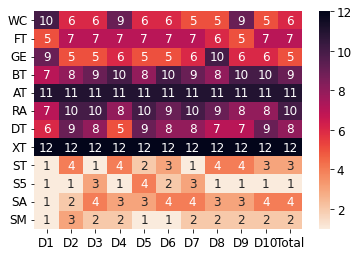

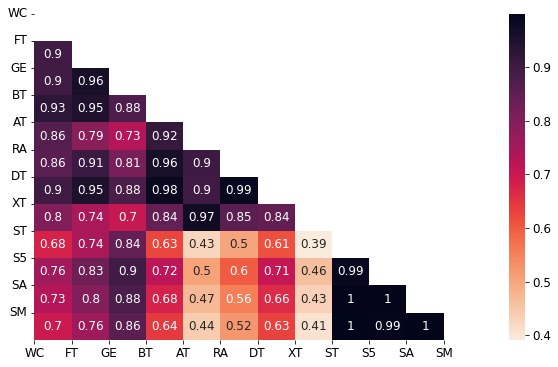

In [15]:
plt.rcParams.update({'font.size': 12, 'font.weight': 'normal'})
block_df2 = filter_df(block_df, [f_k])
print(block_df2.shape)

block_df22 = filter_df(block_df2, [f_agn])
heatmap_plot(block_df22, 'Case', 'Recall', 'Vectorizer', order=case_order, legend=True, reverse_color=True)
plt.savefig(f'../plots_2/effectiveness/blocking/blocking_real_vec_exact_agn_heat.pdf', bbox_inches='tight')

block_df2 = filter_df(block_df, [f_agn, f_k])
print(block_df2.shape)

corr_plot(block_df2, 'Case', 'Recall', 'Vectorizer', order=vectorizers_order2, figsize=(10, 6), reverse_color=True)
plt.savefig(f'../plots_2/effectiveness/blocking/blocking_real_vec_exact_agn_corr.pdf', bbox_inches='tight')

## Matching

### Unsupervised

### Unsupervised.Spider Plot

In [25]:
import plotly.graph_objects as go

plt.rcParams.update({'font.size': 12, 'font.weight': 'normal'})

for metric in ['Precision', 'Recall', 'F1']:
    match_df2 = match_df_best.pivot(index='Case', columns='Vectorizer', values=metric)

    total_cols = {'static': ['WC', 'FT', 'GE'],
                  'BERT': ['BT', 'AT', 'RA', 'DT', 'XT'],
                  'SBERT': ['ST', 'S5', 'SA', 'SM']}

    theta_case_order = case_order + [case_order[0]]
    for grp, cols in total_cols.items():
        fig = go.Figure()
        fig.update_layout(font=dict(size=25,),
                          polar=dict(radialaxis=dict(dtick=0.2), angularaxis=dict(direction="clockwise", rotation=90)),
                          legend=dict(orientation="h", yanchor="bottom", y=1.10, xanchor="center", x=0.5),
                         )
        for col in cols:
            r = list(match_df2[col][case_order].values)
            fig.add_trace(go.Scatterpolar(r=r+[r[0]], theta=theta_case_order, name=col))

        #if metric != 'Precision':
        #    fig.update_layout(showlegend=False)
        fig.show()
        path = f"../plots_2/effectiveness/unsup_matching/unsup_matching_{metric}_{grp}.pdf"
        os.makedirs(os.path.dirname(path), exist_ok=True)
        fig.write_image(path)
        
    match_block_df2 = match_block_df.pivot(index='Case', columns='Vectorizer', values=metric)
        
    match_df3 = pd.DataFrame()
    match_df3['S5'] = match_block_df2['S5']
    match_df3['ZR'] = zeroer_df[metric.lower()]
    match_df3 = match_df3.fillna(0) # what about missing values?

    theta_case_order = case_order + [case_order[0]]
    fig = go.Figure()
    fig.update_layout(font=dict(size=25,), 
                      polar=dict(radialaxis=dict(dtick=0.2), angularaxis=dict(direction="clockwise", rotation=90)),
                      legend=dict(orientation="h", yanchor="bottom", y=1.10, xanchor="center", x=0.5),
                     )

    for col in match_df3.columns:
        r = list(match_df3[col][case_order].values)
        fig.add_trace(go.Scatterpolar(r=r+ [r[0]], theta=theta_case_order, name=col))

    #if metric != 'Precision':
    #    fig.update_layout(showlegend=False)
    fig.show()
    fig.write_image(f"../plots_2/effectiveness/unsup_matching/unsup_matching_{metric}_sota.pdf")     

### Unsupervised.Heatmap

C:\Users\zeus8\Downloads\jupyter\jupyter\utils.py:93: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



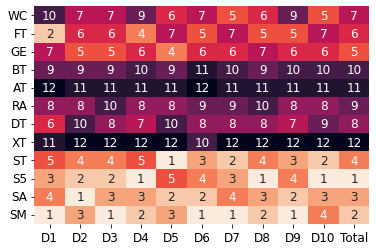

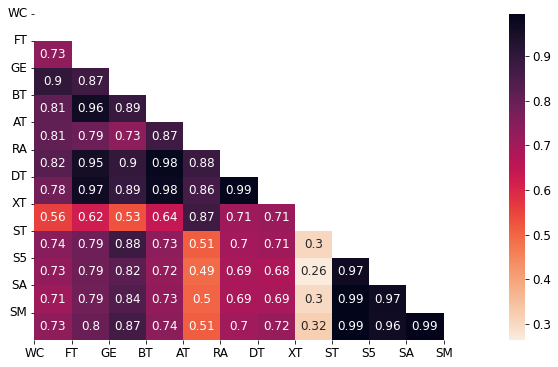

In [26]:
plt.rcParams.update({'font.size': 12, 'font.weight': 'normal'})
heatmap_plot(match_df_best, 'Case', 'F1', 'Vectorizer', order=case_order, reverse_color=True)
plt.savefig(f'../plots_2/effectiveness/unsup_matching/matching_unsupervised_heat.pdf', bbox_inches='tight')

plt.rcParams.update({'font.size': 12, 'font.weight': 'normal'})

corr_plot(match_df_best, 'Case', 'F1', 'Vectorizer', order=vectorizers_order2, figsize=(10, 6), reverse_color=True)
plt.savefig(f'../plots_2/effectiveness/unsup_matching/matching_unsupervised_corr.pdf', bbox_inches='tight')
plt.show()

## Supervised

### Supervised.Spider plots

In [29]:
import plotly.graph_objects as go

plt.rcParams.update({'font.size': 12, 'font.weight': 'normal'})

match_df_sup2 = pd.concat([match_df_sup[['f1', 'model_type', 'data_name']], sup_sota_df]).reset_index(drop=True)
match_df_sup2 = match_df_sup2.pivot(index='data_name', columns='model_type', values='f1')

total_cols = {'static': ['FT', 'GE'],
              'BERT': ['BT', 'AT', 'RA', 'DT', 'XT'],
              'SBERT': ['ST', 'SA', 'SM'],
              'sota': ['DO', 'D+'],}

theta_case_order = case_order2 + [case_order2[0]]
for grp, cols in total_cols.items():
    fig = go.Figure()
    fig.update_layout(font=dict(size=25,), 
                      polar=dict(radialaxis=dict(dtick=0.2), angularaxis=dict(direction="clockwise", rotation=90)),
                     legend=dict(orientation="h", yanchor="bottom", y=1.10, xanchor="center", x=0.5),
                     )

    for col in cols:
        r = list(match_df_sup2[col][case_order2].values)
        fig.add_trace(go.Scatterpolar(r=r+[r[0]], theta=theta_case_order, name=col))

    fig.show()
    path = f"../plots_2/effectiveness/sup_matching/sup_matching_{grp}.pdf"
    os.makedirs(os.path.dirname(path), exist_ok=True)
    fig.write_image(path)

TypeError: cannot concatenate object of type '<class 'list'>'; only Series and DataFrame objs are valid

# Efficiency

## Vectorization

In [32]:
vec_df2 = vec_df.loc[vec_df.Column == 'aggregate value'].reset_index(drop=True)
vec_df2.File = vec_df2.File.apply(lambda x: x[:-4])

vec_df21 = vec_df2.loc[vec_df2['Case'] != 'D5_D6_D7']
vec_df22 = vec_df2.loc[vec_df2['Case'] == 'D5_D6_D7']

cases = {'D5': ('imdb', 'tvdb'), 'D6': ('tmdb', 'tvdb'), 'D7': ('imdb', 'tmdb'),}

for k, v in cases.items():
    for vv in v:
        temp = vec_df22.loc[vec_df22.File == vv].copy()
        temp['Case'] = k
        vec_df21 = pd.concat([vec_df21, temp])
vec_df2 = vec_df21.groupby(['Case', 'Vectorizer'])['Total Time'].sum()
vec_df2 = vec_df2.unstack()
vec_df2 = vec_df2.reset_index(drop=False)
vec_df2['Time'] = 'Vectorization'
#vec_df2 = vec_df2.set_index(['Case', 'Time'])

#tables_times = pd.concat([vec_df2, block_df2, match_df2])
tables_times = vec_df2
tables_times = tables_times.set_index(['Case', 'Time'])
#tables_times.sort_index()
tables_times = tables_times.loc[case_order][vectorizers_order2]
tables_times = tables_times.round(1)

tables_times = tables_times.droplevel(1)

print(tables_times.to_latex())

tables_times

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
Vectorizer &   WC &    FT &   GE &    BT &    AT &    RA &    DT &    XT &    ST &    S5 &    SA &    SM \\
Case &      &       &      &       &       &       &       &       &       &       &       &       \\
\midrule
D1   &  0.0 &   0.2 &  1.9 &   2.6 &   2.4 &   2.3 &   1.3 &   4.0 &   1.1 &   1.1 &   0.7 &   0.5 \\
D2   &  0.1 &   1.6 &  0.2 &   3.1 &   2.4 &   2.3 &   2.2 &   3.3 &   3.4 &   3.4 &   1.8 &   0.9 \\
D3   &  0.9 &   9.6 &  0.4 &  10.1 &   6.7 &   6.3 &   8.6 &   8.3 &  10.3 &  12.4 &   5.8 &   2.3 \\
D4   &  0.2 &   2.5 &  0.3 &   5.9 &   5.2 &   5.3 &   4.2 &   7.8 &   5.1 &   5.4 &   2.8 &   1.4 \\
D5   &  0.4 &   3.8 &  0.4 &  13.6 &  13.0 &  12.9 &   8.7 &  20.3 &  10.7 &  12.1 &   6.0 &   3.2 \\
D6   &  0.6 &   5.5 &  0.5 &  15.4 &  14.3 &  13.8 &  10.4 &  21.3 &  14.9 &  17.2 &   8.2 &   3.9 \\
D7   &  0.4 &   3.6 &  0.4 &  11.9 &  11.2 &  11.4 &   8.0 &  17.7 &   9.7 &  10.4 &   5.3 &   2.8 \\
D8   &  1.0 &  10.0 &  0.8 

C:\Users\zeus8\AppData\Local\Temp\ipykernel_18628\3197620306.py:29: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



Vectorizer,WC,FT,GE,BT,AT,RA,DT,XT,ST,S5,SA,SM
Case,,,,,,,,,,,,
D1,0.0,0.2,1.9,2.6,2.4,2.3,1.3,4.0,1.1,1.1,0.7,0.5
D2,0.1,1.6,0.2,3.1,2.4,2.3,2.2,3.3,3.4,3.4,1.8,0.9
D3,0.9,9.6,0.4,10.1,6.7,6.3,8.6,8.3,10.3,12.4,5.8,2.3
D4,0.2,2.5,0.3,5.9,5.2,5.3,4.2,7.8,5.1,5.4,2.8,1.4
D5,0.4,3.8,0.4,13.6,13.0,12.9,8.7,20.3,10.7,12.1,6.0,3.2
D6,0.6,5.5,0.5,15.4,14.3,13.8,10.4,21.3,14.9,17.2,8.2,3.9
D7,0.4,3.6,0.4,11.9,11.2,11.4,8.0,17.7,9.7,10.4,5.3,2.8
D8,1.0,10.0,0.8,28.8,25.0,24.2,19.5,38.9,28.5,27.3,14.9,6.7
D9,2.4,27.7,1.9,73.4,66.0,65.5,49.9,99.9,58.0,61.5,31.4,16.0


In [33]:
init_times = vec_df21.groupby('Vectorizer')['Init Time'].mean()
init_times = pd.DataFrame(init_times).T
init_times = init_times[vectorizers_order2]
init_times = init_times.round(2)

print(init_times.to_latex())
init_times

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
Vectorizer &    WC &     FT &    GE &    BT &    AT &    RA &   DT &    XT &    ST &    S5 &    SA &    SM \\
\midrule
Init Time &  32.4 &  159.7 &  5.87 &  4.72 &  3.99 &  5.28 &  4.3 &  4.73 &  9.19 &  9.84 &  9.33 &  8.36 \\
\bottomrule
\end{tabular}



C:\Users\zeus8\AppData\Local\Temp\ipykernel_18628\2295920875.py:6: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



Vectorizer,WC,FT,GE,BT,AT,RA,DT,XT,ST,S5,SA,SM
Init Time,32.4,159.7,5.87,4.72,3.99,5.28,4.3,4.73,9.19,9.84,9.33,8.36


In [34]:
vect_total_times = pd.DataFrame()
for col in tables_times:
     vect_total_times[col] = tables_times[col]+init_times[col]['Init Time']
vect_total_times

,WC,FT,GE,BT,AT,RA,DT,XT,ST,S5,SA,SM
Case,,,,,,,,,,,,
D1,32.4,159.9,7.77,7.32,6.39,7.58,5.6,8.73,10.29,10.94,10.03,8.86
D2,32.5,161.3,6.07,7.82,6.39,7.58,6.5,8.03,12.59,13.24,11.13,9.26
D3,33.3,169.3,6.27,14.82,10.69,11.58,12.9,13.03,19.49,22.24,15.13,10.66
D4,32.6,162.2,6.17,10.62,9.19,10.58,8.5,12.53,14.29,15.24,12.13,9.76
D5,32.8,163.5,6.27,18.32,16.99,18.18,13.0,25.03,19.89,21.94,15.33,11.56
D6,33.0,165.2,6.37,20.12,18.29,19.08,14.7,26.03,24.09,27.04,17.53,12.26
D7,32.8,163.3,6.27,16.62,15.19,16.68,12.3,22.43,18.89,20.24,14.63,11.16
D8,33.4,169.7,6.67,33.52,28.99,29.48,23.8,43.63,37.69,37.14,24.23,15.06
D9,34.8,187.4,7.77,78.12,69.99,70.78,54.2,104.63,67.19,71.34,40.73,24.36


## Blocking

### Blocking.Pareto

In [36]:
plt.rcParams.update({'font.size': 18, 'font.weight': 'normal'})

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

block_pareto = pd.DataFrame()

block_df2 = filter_df(block_df, [f_k, f_agn])
block_df2 = block_df2.pivot(index='Case', columns='Vectorizer', values='Time')
block_df2 = block_df2+vect_total_times
block_df2 = block_df2.apply(lambda x: x/x.min(), axis=1) #normalize per dataset
block_pareto['Normalized Time'] = block_df2.mean()

block_df2 = filter_df(block_df, [f_k, f_agn])
block_df2 = block_df2.pivot(index='Case', columns='Vectorizer', values='Recall')
block_pareto['(a) - Recall'] = block_df2.mean()

block_pareto['Size'] = 20
block_pareto['Group'] = pd.Series(categories)

block_pareto = block_pareto.sort_values(by=['Group'], key=lambda x: x.map({v: i for i, v in enumerate(['Static', 'BERT', 'SBERT'])}))

fig1 = px.scatter(block_pareto, y='Normalized Time', x='(a) - Recall', hover_name=block_pareto.index,
                  size='Size', color='Group', text=block_pareto.index)
fig1.update_layout(yaxis_range=[0,25], xaxis_range=[0,1], font=dict(size=20,), 
                  legend=dict(orientation="h", yanchor="bottom", y=1.00, xanchor="center", x=0.5, title=''))
fig1.show()

path = f"../plots_2/efficiency/blocking_pareto.pdf"
os.makedirs(os.path.dirname(path), exist_ok=True)
fig1.write_image(path)

In [51]:
df1 = deepblocker_df[['time', 'k', 'case']].pivot(values='time', columns='k', index='case')
df2 = block_df.loc[block_df.Vectorizer=='S5'].pivot(index='Case', columns='k', values='Time')
df2 = df2.apply(lambda x: x.add(vect_total_times['S5']))
sota_blocking_table = pd.concat([df1, df2], axis=1)

sota_blocking_table.columns = pd.MultiIndex.from_product([['DeepBlocker', 'S-T5'], [1,5,10]])
sota_blocking_table = sota_blocking_table.round(1)

print(sota_blocking_table.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{DeepBlocker} & \multicolumn{3}{l}{S-T5} \\
{} &          1  &     5  &     10 &    1  &    5  &    10 \\
\midrule
D1  &         8.8 &    8.4 &    8.3 &  11.0 &  11.0 &  11.1 \\
D10 &       150.0 &  144.0 &  144.8 &  40.5 &  41.2 &  42.1 \\
D2  &         9.1 &    9.1 &    9.2 &  13.3 &  13.3 &  13.3 \\
D3  &        19.1 &   19.1 &   19.0 &  22.3 &  22.4 &  22.5 \\
D4  &        12.9 &   13.3 &   13.2 &  15.3 &  15.3 &  15.5 \\
D5  &        24.8 &   26.3 &   26.5 &  22.0 &  22.3 &  22.6 \\
D6  &        29.6 &   29.8 &   29.7 &  27.2 &  27.4 &  27.7 \\
D7  &        24.1 &   24.3 &   23.9 &  20.3 &  20.5 &  20.7 \\
D8  &        43.3 &   43.0 &   43.0 &  37.4 &  38.1 &  39.1 \\
D9  &       103.7 &  103.7 &  103.4 &  72.2 &  74.1 &  76.7 \\
\bottomrule
\end{tabular}



C:\Users\zeus8\AppData\Local\Temp\ipykernel_18628\572225830.py:9: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



## Unsup Matching

In [52]:
match_df_bars = match_df_best.pivot(index='Case', columns='Vectorizer', values='Matching Time').loc[case_order, vectorizers_order2]
match_df_bars = match_df_bars.round(1)
print(match_df_bars.to_latex())

match_df_bars

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
Vectorizer &     WC &    FT &    GE &      BT &      AT &     RA &     DT &      XT &     ST &   S5 &   SA &   SM \\
Case &        &       &       &         &         &        &        &         &        &      &      &      \\
\midrule
D1   &    0.0 &   0.0 &   0.0 &     0.1 &     0.3 &    0.0 &    0.0 &     0.0 &    0.2 &  0.0 &  0.0 &  0.0 \\
D2   &    2.0 &   0.8 &   0.8 &     1.4 &     0.9 &    2.4 &    1.8 &     2.6 &    0.1 &  0.2 &  1.0 &  0.1 \\
D3   &    9.2 &   8.4 &   3.1 &     3.4 &     1.1 &    0.7 &    0.2 &     7.7 &    0.1 &  0.2 &  0.9 &  0.0 \\
D4   &    1.2 &   3.5 &   0.0 &     0.9 &     7.2 &    2.2 &    0.3 &    12.5 &    0.1 &  0.0 &  0.0 &  0.0 \\
D5   &    0.4 &  24.0 &   0.7 &    22.7 &     0.0 &    9.5 &   10.9 &     0.0 &    0.0 &  0.3 &  0.0 &  0.0 \\
D6   &    0.0 &   0.0 &   0.0 &     0.0 &     0.0 &    0.0 &    0.0 &     0.0 &    0.1 &  0.1 &  0.1 &  0.1 \\
D7   &    3.0 &   2.6 &   8.2 &    10.6 &     3.7 &    4.

C:\Users\zeus8\AppData\Local\Temp\ipykernel_18628\4020952979.py:3: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



Vectorizer,WC,FT,GE,BT,AT,RA,DT,XT,ST,S5,SA,SM
Case,,,,,,,,,,,,
D1,0.0,0.0,0.0,0.1,0.3,0.0,0.0,0.0,0.2,0.0,0.0,0.0
D2,2.0,0.8,0.8,1.4,0.9,2.4,1.8,2.6,0.1,0.2,1.0,0.1
D3,9.2,8.4,3.1,3.4,1.1,0.7,0.2,7.7,0.1,0.2,0.9,0.0
D4,1.2,3.5,0.0,0.9,7.2,2.2,0.3,12.5,0.1,0.0,0.0,0.0
D5,0.4,24.0,0.7,22.7,0.0,9.5,10.9,0.0,0.0,0.3,0.0,0.0
D6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.1
D7,3.0,2.6,8.2,10.6,3.7,4.9,3.1,61.5,0.2,0.0,0.3,0.1
D8,0.0,0.0,0.0,0.0,1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D9,1.9,0.7,9.4,1.7,161.8,0.1,0.7,157.8,0.0,0.1,0.0,0.1


### UnsupMatching.Pareto

In [53]:
plt.rcParams.update({'font.size': 18, 'font.weight': 'normal'})

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

unsup_match_pareto = pd.DataFrame()

match_df_2 = match_df_best.pivot(index='Case', columns='Vectorizer', values='Matching Time')
match_df_2 = match_df_2+vect_total_times
match_df_2 = match_df_2.apply(lambda x: x/x.min(), axis=1) #normalize per dataset
unsup_match_pareto['Normalized Time'] = match_df_2.mean()

match_df_2 = match_df_best.pivot(index='Case', columns='Vectorizer', values='F1')
unsup_match_pareto['(b) - F1'] = match_df_2.mean()

unsup_match_pareto['Size'] = 20
unsup_match_pareto['Group'] = pd.Series(categories)
unsup_match_pareto = unsup_match_pareto.sort_values(by=['Group'], key=lambda x: x.map({v: i for i, v in enumerate(['Static', 'BERT', 'SBERT'])}))

fig1 = px.scatter(unsup_match_pareto, y='Normalized Time', x='(b) - F1', hover_name=unsup_match_pareto.index,
                  size='Size', color='Group', text=unsup_match_pareto.index)
fig1.update_layout(yaxis_range=[0,25], xaxis_range=[0,1], font=dict(size=20,), 
                  legend=dict(orientation="h", yanchor="bottom", y=1.00, xanchor="center", x=0.5, title=''))
fig1.show()
fig1.write_image(f"../plots_2/efficiency/unsup_matching_pareto.pdf")

### UnsupMatching.SotA

In [54]:
df1 = zeroer_df[['features', 'zeroer']]
df2 = match_block_df.set_index('Case')[['Blocking Time', 'Matching Time']]
df2['Blocking Time'] = df2['Blocking Time'] + vect_total_times['S5']

match_df3 = pd.concat([df1, df2], axis=1)
match_df3 = match_df3.round(3)
match_df3 = match_df3.fillna('-')
match_df3 = match_df3.loc[case_order]
match_df3.columns = pd.MultiIndex.from_product([['ZeroER', 'S-T5'], ['Preprocessing', 'Matching']])

print(match_df3.to_latex())

match_df3

\begin{tabular}{lllrr}
\toprule
{} & \multicolumn{2}{l}{ZeroER} & \multicolumn{2}{l}{S-T5} \\
{} & Preprocessing & Matching & Preprocessing & Matching \\
\midrule
D1  &          2.12 &    0.383 &        13.146 &    0.001 \\
D2  &      1727.549 &   70.702 &        13.511 &    0.003 \\
D3  &             - &        - &        22.558 &    0.004 \\
D4  &      9595.277 &   113.19 &        15.833 &    0.009 \\
D5  &      1291.435 &    9.768 &        23.164 &    0.012 \\
D6  &             - &        - &        28.363 &    0.016 \\
D7  &       1598.54 &  338.195 &        21.385 &    0.013 \\
D8  &             - &        - &        37.733 &    0.008 \\
D9  &             - &        - &        71.970 &    0.010 \\
D10 &             - &        - &        46.284 &    0.096 \\
\bottomrule
\end{tabular}



C:\Users\zeus8\AppData\Local\Temp\ipykernel_18628\919423134.py:11: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



ZeroER                   S-T5         
    Preprocessing Matching Preprocessing Matching
D1           2.12    0.383        13.146    0.001
D2       1727.549   70.702        13.511    0.003
D3              -        -        22.558    0.004
D4       9595.277   113.19        15.833    0.009
D5       1291.435    9.768        23.164    0.012
D6              -        -        28.363    0.016
D7        1598.54  338.195        21.385    0.013
D8              -        -        37.733    0.008
D9              -        -        71.970    0.010
D10             -        -        46.284    0.096

## Supervised

### Table

In [56]:
order = [[f'DSM{i}', j] for i in range(1, 6) for j in ['training_time', 'testing_time']]
match_df_sup_tab = match_df_sup.pivot(index='model_type', columns='data_name', values=['training_time', 'testing_time'])
match_df_sup_tab = match_df_sup_tab.round(1)
c = [v for v in vectorizers_order2 if v not in ['WC', 'S5']]
match_df_sup_tab = match_df_sup_tab.swaplevel(axis=1)
match_df_sup_tab = match_df_sup_tab.loc[c, order]
match_df_sup_tab.columns = pd.MultiIndex.from_product([[f'DSM{i}' for i in range(1, 6)], ['$t_t$', '$t_e$']])

print(match_df_sup_tab.to_latex())
match_df_sup_tab

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} & \multicolumn{2}{l}{DSM1} & \multicolumn{2}{l}{DSM2} & \multicolumn{2}{l}{DSM3} & \multicolumn{2}{l}{DSM4} & \multicolumn{2}{l}{DSM5} \\
{} &   \$t\_t\$ & \$t\_e\$ &  \$t\_t\$ & \$t\_e\$ &   \$t\_t\$ & \$t\_e\$ &   \$t\_t\$ & \$t\_e\$ &   \$t\_t\$ & \$t\_e\$ \\
model\_type &         &       &        &       &         &       &         &       &         &       \\
\midrule
FT         &   851.9 &   4.8 &  100.9 &   0.6 &  1155.0 &   6.9 &  2527.3 &  14.8 &   882.1 &   4.7 \\
GE         &   847.0 &   4.8 &  101.4 &   0.6 &  1157.2 &   6.9 &  2534.3 &  14.7 &   876.9 &   4.7 \\
BT         &  1811.2 &  11.2 &   66.3 &   0.4 &  1525.9 &   9.6 &  2615.9 &  15.8 &  1093.8 &   6.8 \\
AT         &  1700.5 &  12.0 &   62.8 &   0.5 &  1448.4 &  10.4 &  2422.1 &  17.0 &  1026.6 &   7.4 \\
RA         &  1810.8 &  11.2 &   66.2 &   0.4 &  1548.7 &   9.6 &  2666.9 &  15.8 &  1111.3 &   6.9 \\
DT         &   915.2 &   5.5 &   34.0 &   0.2 &   779.2 &   4.8 &  1

C:\Users\zeus8\AppData\Local\Temp\ipykernel_18628\3873535148.py:9: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



DSM1         DSM2          DSM3          DSM4          DSM5  \
             $t_t$ $t_e$  $t_t$ $t_e$   $t_t$ $t_e$   $t_t$ $t_e$   $t_t$   
model_type                                                                  
FT           851.9   4.8  100.9   0.6  1155.0   6.9  2527.3  14.8   882.1   
GE           847.0   4.8  101.4   0.6  1157.2   6.9  2534.3  14.7   876.9   
BT          1811.2  11.2   66.3   0.4  1525.9   9.6  2615.9  15.8  1093.8   
AT          1700.5  12.0   62.8   0.5  1448.4  10.4  2422.1  17.0  1026.6   
RA          1810.8  11.2   66.2   0.4  1548.7   9.6  2666.9  15.8  1111.3   
DT           915.2   5.5   34.0   0.2   779.2   4.8  1341.9   7.9   559.1   
XT          2920.7  24.2   92.2   0.7  2120.5  15.9  3196.5  21.0  1423.2   
ST          1667.5  10.5   63.4   0.4  1475.8   8.8  2549.9  14.4  1076.8   
SA           828.2   5.0   31.4   0.2   716.9   4.3  1253.7   7.1   518.1   
SM           406.6   2.1   13.4   0.1   299.2   1.7   521.6   2.7   216.6   

                  
           $t_e$  
model_type        
FT           4.7  
GE           4.7  
BT           6.8  
AT           7.4  
RA           6.9  
DT           3.4  
XT          10.1  
ST           6.3  
SA           3.1  
SM           1.2

### SupMatching.Pareto

In [58]:
plt.rcParams.update({'font.size': 18, 'font.weight': 'normal'})

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

sup_match_pareto = pd.DataFrame()

match_df_sup['total_time'] = match_df_sup['training_time'] + match_df_sup['testing_time']

match_df_2 = match_df_sup.pivot(index='data_name', columns='model_type', values='testing_time')
match_df_2 = match_df_2.apply(lambda x: x/x.min(), axis=1) #normalize per dataset
sup_match_pareto['Normalized Time'] = match_df_2.mean()

match_df_2 = match_df_sup.pivot(index='data_name', columns='model_type', values='f1')
sup_match_pareto['(c) - F1'] = match_df_2.mean()

sup_match_pareto['Size'] = 20
sup_match_pareto['Group'] = pd.Series(categories)
sup_match_pareto = sup_match_pareto.sort_values(by=['Group'], key=lambda x: x.map({v: i for i, v in enumerate(['Static', 'BERT', 'SBERT'])}))

fig1 = px.scatter(sup_match_pareto, y='Normalized Time', x='(c) - F1', hover_name=sup_match_pareto.index,
                  size='Size', color='Group', text=sup_match_pareto.index)
fig1.update_layout(yaxis_range=[0,10], xaxis_range=[0,1], font=dict(size=20,), 
                  legend=dict(orientation="h", yanchor="bottom", y=1.00, xanchor="center", x=0.5, title=''))
fig1.show()
fig1.write_image(f"../plots_2/efficiency/sup_matching_pareto.pdf")

## Scalability

## Vectorization

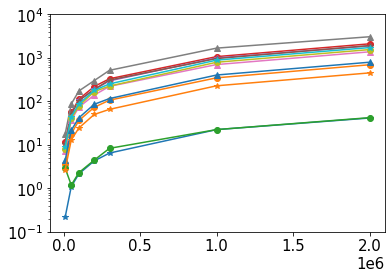

In [61]:
files = ['10K', '50K', '100K', '200K', '300K', '1M', '2M']
markers = ['*', 'o', 'o', 'o', '*', '*', '^', '^', 'o', '*', '^', '*']


plt.rcParams.update({'font.size': 15, 'font.weight': 'normal'})
with open(input_dir_sa +'vectorization_synthetic.txt') as f:
    lines = []
    for line in f.readlines():
        line = json.loads(line)
        lines.append((line['vectorizer'], line['time'], line['file'], line['memory']['process']['rss']))
    
vec_df2 = pd.DataFrame(lines, columns=['Vectorizer', 'Total Time', 'File', 'Memory Process'])
vec_df2['File'] = vec_df2['File'].apply(lambda x: x.split('.')[0])
vec_df2['File'] = vec_df2['File'].apply(lambda x: int(x[:-1])* (1000 if x[-1] == 'K' else 1000000) )
vec_df2['Vectorizer'] = vec_df2['Vectorizer'].apply(lambda x: x[0]+x[-1]).str.upper()

fig, axes = plt.subplots(nrows=1, ncols=1)
line_plot(vec_df2, 'Vectorizer', 'Total Time', 'File', legend=False,
          ax=axes, markers=markers, yscale='log', xlabel='', order=vectorizers_order2,
              ylabel='', ylim=(0.1, pow(10, 4))
             )

path = f'../plots_2/scalability/vectorization_synthetic_time.pdf'
os.makedirs(os.path.dirname(path), exist_ok=True)
plt.savefig(path, bbox_inches='tight')

## Blocking

In [62]:
files = ['10K.csv', '50K.csv', '100K.csv', '200K.csv', '300K.csv', '1M.csv', '2M.csv']
markers = ['*', 'o', 'o', 'o', '*', '*', '^', '^', 'o', '*', '^', '*']

block_df2 = pd.read_csv(input_dir_sa + 'blocking_euclidean_synthetic.csv')
#results.Case = results.Case.apply(lambda x: files[x].split('.')[0])
block_df2.Case = block_df2.Case.apply(lambda x: files[x])
block_df2['Case'] = block_df2['Case'].apply(lambda x: x.split('.')[0])
block_df2['Case'] = block_df2['Case'].apply(lambda x: int(x[:-1])* (1000 if x[-1] == 'K' else 1000000) )
block_df2['Vectorizer'] = block_df2['Vectorizer'].apply(lambda x: x[0]+x[-1]).str.upper()
print(block_df2.shape)
block_df2 = filter_df(block_df2, [('k', 'eq', 10), f_i2q])
print(block_df2.shape)
block_df2

(84, 9)
(84, 9)


,Case,Columns,Vectorizer,k,Direction,Exact,Recall,Precision,Time
0,10000,2,WC,10,i2q,approx,0.415049,0.042377,0.249696
1,10000,2,FT,10,i2q,approx,0.900862,0.091399,0.317562
2,10000,2,GE,10,i2q,approx,0.677427,0.070728,0.276546
3,10000,2,BT,10,i2q,approx,0.404595,0.041367,1.222913
4,10000,2,DT,10,i2q,approx,0.436875,0.046660,1.218240
...,...,...,...,...,...,...,...,...,...
79,2000000,2,AT,10,i2q,approx,0.049853,0.005049,530.576945
80,2000000,2,ST,10,i2q,approx,0.317400,0.031571,581.581631
81,2000000,2,S5,10,i2q,approx,0.782894,0.084614,758.130276
82,2000000,2,SA,10,i2q,approx,0.438275,0.043047,678.534146


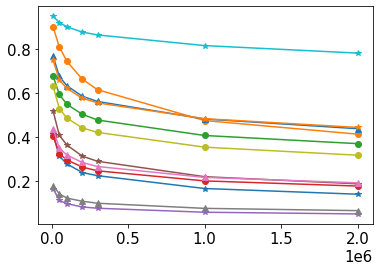

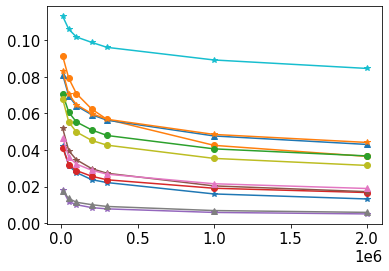

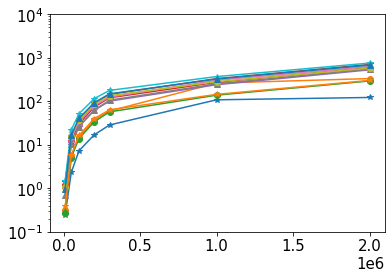

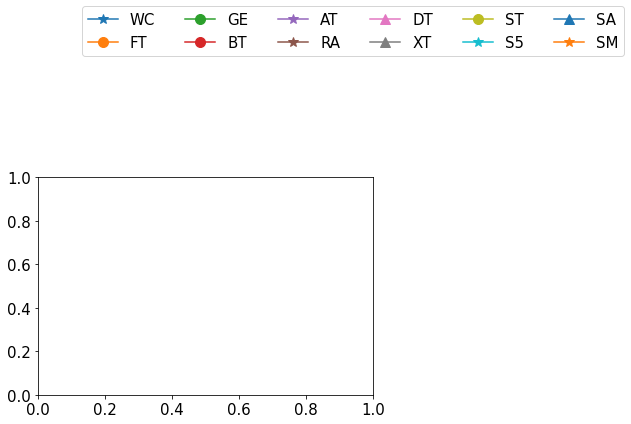

In [63]:
block_df3 = filter_df(block_df2, [f_app])
fig, axes = plt.subplots(nrows=1, ncols=1)
line_plot(block_df3, 'Vectorizer', 'Recall', 'Case', legend=False, markers=markers, ax=axes, title='', ylabel='', order=vectorizers_order2)
plt.savefig(f'../plots_2/scalability/blocking_synthetic_recall_approx.pdf', bbox_inches='tight')

fig, axes = plt.subplots(nrows=1, ncols=1)
line_plot(block_df3, 'Vectorizer', 'Precision', 'Case', legend=False, markers=markers, ax=axes, title='', ylabel='', order=vectorizers_order2)
plt.savefig(f'../plots_2/scalability/blocking_synthetic_precision_approx.pdf', bbox_inches='tight')

fig, axes = plt.subplots(nrows=1, ncols=1)
leg = line_plot(block_df3, 'Vectorizer', 'Time', 'Case', legend=True, markers=markers, ax=axes, title='', yscale='log', ylabel='', order=vectorizers_order2, ylim=(0.1, pow(10, 4)))
leg.set_visible(False)
plt.savefig(f'../plots_2/scalability/blocking_synthetic_time_approx.pdf', bbox_inches='tight')

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig = plt.figure()
fig.add_subplot(111)
    
#leg = [Patch(facecolor=c, alpha=1.0, label=v, edgecolor='#000') for c, v in zip(2*colors, vectorizers_order2)]

leg = [ Line2D([], [], color=c, marker=m, markersize=10, label=v)
         for c, v, m in zip(2*colors, vectorizers_order2, 2*markers)]
#leg = fig.legend(handles=leg, ncol=len(leg), bbox_to_anchor=(1.5, 1.5))    
leg = fig.legend(handles=leg, ncol=len(leg)//2, bbox_to_anchor=(1.5, 1.5))    
#leg = fig.legend(handles=leg, bbox_to_anchor=(1.5, 1.5))    

leg.set_visible(True)

expand=[-5,-5,5,5]
fig  = leg.figure
fig.canvas.draw()
bbox  = leg.get_window_extent()
bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
fig.savefig('../plots_2/scalability/blocking_synthetic_legend.pdf', dpi="figure", bbox_inches=bbox)    

plt.show()